# Specific Task V: Exploring Transformers

<u>Dataset Used</u>: https://drive.google.com/file/d/16Y1taQoTeUTP5rGpB0tuPZ_S30acvnqr/view

<u>Evaluation Metrics</u>: ROC curve (Receiver Operating Characteristic curve) and AUC score (Area Under the ROC Curve)

<u>Approach Used</u>: Train and evaluate the performance of different ViTs and Ensembles. Combine (average) the predictions of all the models to get the best results.

# 1. Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import os
import tarfile
import random
import platform
from tqdm import tqdm
import gc
from dataclasses import dataclass
from collections import Counter
from collections import defaultdict

import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, confusion_matrix, roc_curve, auc, roc_auc_score

import albumentations as A
# from albumentations.pytorch import ToTensorV2

import torch
import torchvision.transforms as transforms
import torchvision.transforms.functional as fn
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models


from PIL import Image
import cv2
import timm

import warnings
warnings.filterwarnings("ignore")

Check for GPU availability

In [ ]:
!nvidia-smi

Thu Mar  9 19:46:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Define a `CONFIG` class containing different hyperparameters for our models, set a common random seed and use the `DEVICE` (GPU) to train the models.

In [ ]:
@dataclass
class CONFIG:
    MODEL_NAMES = ["vit_base_patch16_224",
                   "swin_base_patch4_window7_224"]
    IMAGE_SIZE = (224, 224)
    BATCH_SIZE = 64
    SWIN_BATCH_SIZE = 16 # reduce batch size for swin to avoid OOM errors
    NUM_WORKERS = 8
    DROPOUT = 0.3
    RANDOM_SEED = 42
    LEARNING_RATE = 1e-5
    EPOCHS = 20
    
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
def get_device():
    global DEVICE
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
        DEVICE = torch.device("cuda:0")
    else:
        print("\n[INFO] GPU not found. Using CPU: {}\n".format(platform.processor()))
        DEVICE = torch.device("cpu")

set_seed(CONFIG.RANDOM_SEED)
get_device()

[INFO] Using GPU: Tesla P100-PCIE-16GB



Extract the data from the `.tgz` file

In [ ]:
tar = tarfile.open("/kaggle/input/gsoc-deep-lense-task-v/lenses (1).tgz", "r:gz")

tar_directory_structure = tar.getnames()

paths_to_discard = ['lenses', 'lenses/no_sub', 'lenses/sub']

for paths in paths_to_discard:
    if(paths in tar_directory_structure):
        tar_directory_structure.remove(paths)

tar.extractall(path=".", members=None, numeric_owner=False)

Get file paths and labels for the dataset

In [ ]:
image_path_list = []
labels_list = []

for image_path in tar_directory_structure:
    image_path_list.append(image_path)
    labels_list.append(image_path.split('/')[-2])
    
random_no = random.randint(0, len(labels_list))
    
print(f"Image list length: {len(image_path_list)}")
print(f"Labels list length: {len(labels_list)}")

print(f"Random Image: {image_path_list[random_no]}")
print(f"Label: {labels_list[random_no]}")

Image list length: 10000
Labels list length: 10000
Random Image: lenses/no_sub/image_213295283789541651063641904131139665328.jpg
Label: no_sub


Label Encode the targets 

In [ ]:
le = preprocessing.LabelEncoder()
labels_list = le.fit_transform(labels_list)
print(f"Label encoder classes: {le.classes_}")
print(f"New labels: {labels_list}")
print(f"Length of labels list: {len(labels_list)}")

Label encoder classes: ['no_sub' 'sub']
New labels: [0 0 0 ... 1 1 1]
Length of labels list: 10000


Visualize a random image of the dataset

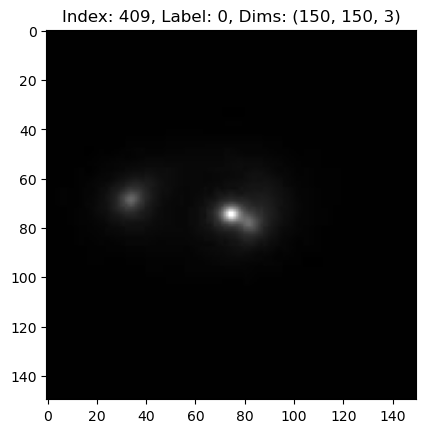

In [ ]:
def display_random_image(image_path_list, labels_list):
    
    idx = random.randint(0, len(labels_list))
    
    img = cv2.imread(f"{image_path_list[idx]}")
    plt.imshow(img)
    plt.title(f"Index: {idx}, Label: {labels_list[idx]}, Dims: {img.shape}")
    plt.show()

display_random_image(image_path_list, labels_list)

# 2. Train Test Split

The train:test split is in the ratio 90:10, as mentioned in the submission guidelines 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(image_path_list, labels_list, test_size=0.1,
                                                    random_state=CONFIG.RANDOM_SEED, stratify=labels_list)

Verify whether the split was done correctly or not

In [ ]:
print(f"Length of training data: {len(X_train)}")
print(f"Length of testing data: {len(X_test)}")
print(f"Length of training labels: {len(y_train)}")
print(f"Length of testing labels: {len(y_test)}")

Length of training data: 9000
Length of testing data: 1000
Length of training labels: 9000
Length of testing labels: 1000


# 3. Data Augmentations

In [ ]:
train_transform = A.Compose(
    [
        A.HorizontalFlip(p=0.3),
        A.VerticalFlip(p=0.3),
        A.Rotate(limit=40, p=0.9, border_mode=cv2.BORDER_CONSTANT),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ]
)

val_transform = A.Compose(
    [
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ]
)

# 4. Creating the Dataset

In [ ]:
class GSoCDeepLensePrivateDatasetSpecificTask5(Dataset):
    
    def __init__(self, image_paths, labels, transform=False):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.resize(image, CONFIG.IMAGE_SIZE)
        label = self.labels[idx]
        
        if(self.transform is not None):
            image = self.transform(image=image)["image"]
            
        return image, label

train_dataset = GSoCDeepLensePrivateDatasetSpecificTask5(image_paths=X_train, labels=y_train, transform=train_transform)
val_dataset = GSoCDeepLensePrivateDatasetSpecificTask5(image_paths=X_test, labels=y_test, transform=val_transform)

# 5. Visualizing Images

Taking a look at the images present in the train and valid sets respectively

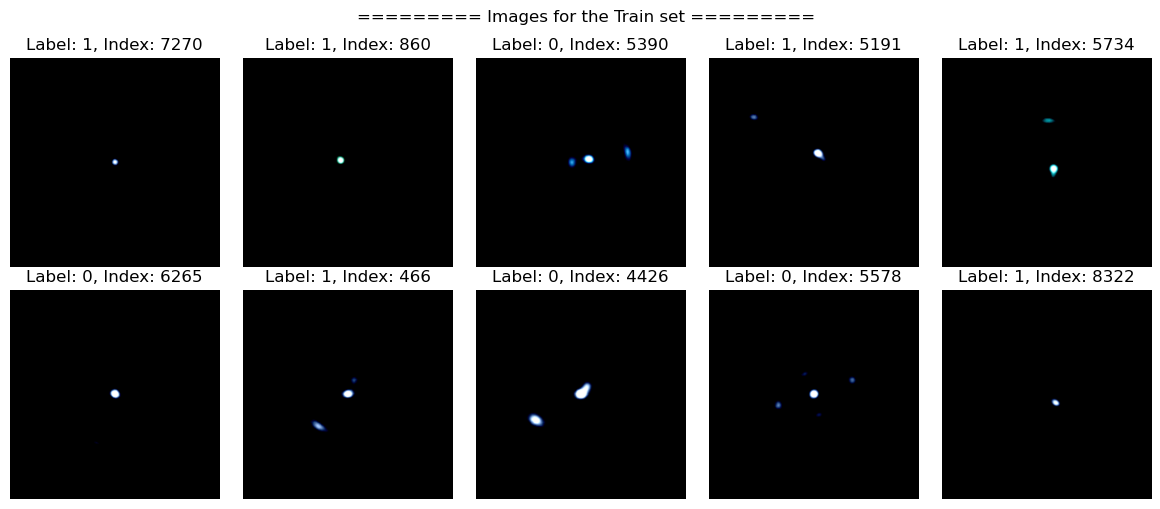

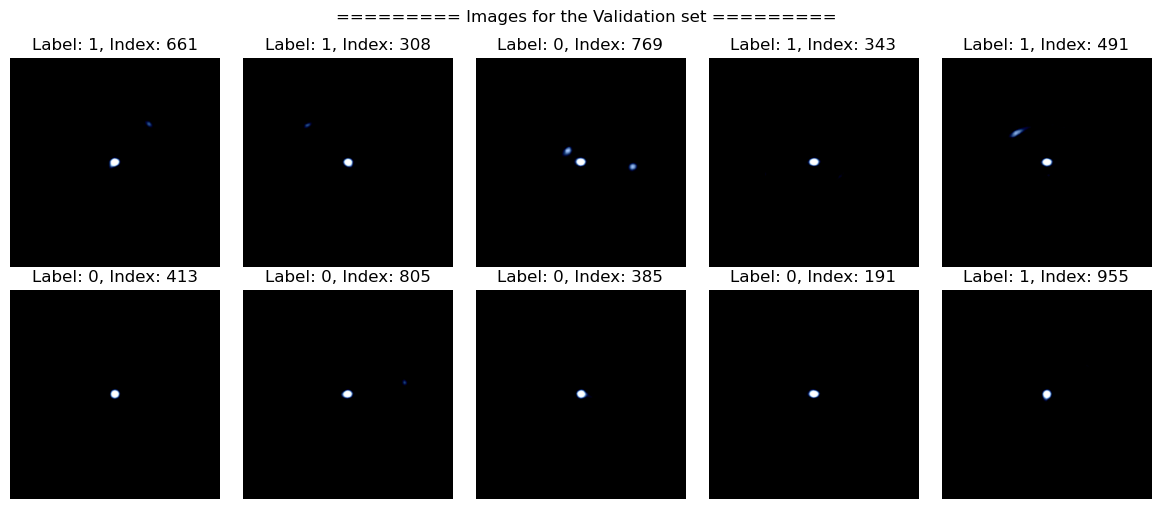

In [ ]:
def visualize_images(dataset_input, dataset_type, samples, cols):
    
    dataset_len = len(dataset_input)
    dataset = dataset_input
    
    rows = samples // cols
    
    fig, ax = plt.subplots(nrows = rows, ncols = cols, figsize=(12, 8))
    fig.suptitle(f"========= Images for the {dataset_type.title()} set =========", y=0.9)
    
    for i in range(samples):
        idx = np.random.randint(0, dataset_len)
        image, label = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
        ax.ravel()[i].set_title(f"Label: {label}, Index: {idx}")
        
    plt.tight_layout(rect=[0, 0.2, 0.99, 0.975], h_pad=2.1, pad=1.7)
    plt.show()
    
visualize_images(dataset_input=train_dataset, dataset_type="train", samples=10, cols=5)
visualize_images(dataset_input=val_dataset, dataset_type="validation", samples=10, cols=5)

# 6. Create Dataloaders

In [ ]:
def make_data_loader(dataset, shuffle):
    
    loader = DataLoader(dataset, batch_size=CONFIG.SWIN_BATCH_SIZE, num_workers=CONFIG.NUM_WORKERS, shuffle=shuffle)
    
    return loader

# img, label = next(iter(train_loader)) # batch of 64
train_loader = make_data_loader(dataset=train_dataset, shuffle=True)
val_loader = make_data_loader(dataset=val_dataset, shuffle=False)

Check `timm` for `swin` transformers. Swin transformers are a type of Vision Transformers (ViTs).

In [ ]:
# all_pretrained_models_available = timm.list_models(pretrained=True)
# all_pretrained_models_available
print("Available Swin Transformer Models:")
timm.list_models("swin*")

Available Swin Transformer Models:


['swin_base_patch4_window7_224',
 'swin_base_patch4_window7_224_in22k',
 'swin_base_patch4_window12_384',
 'swin_base_patch4_window12_384_in22k',
 'swin_large_patch4_window7_224',
 'swin_large_patch4_window7_224_in22k',
 'swin_large_patch4_window12_384',
 'swin_large_patch4_window12_384_in22k',
 'swin_s3_base_224',
 'swin_s3_small_224',
 'swin_s3_tiny_224',
 'swin_small_patch4_window7_224',
 'swin_tiny_patch4_window7_224',
 'swinv2_base_window8_256',
 'swinv2_base_window12_192_22k',
 'swinv2_base_window12to16_192to256_22kft1k',
 'swinv2_base_window12to24_192to384_22kft1k',
 'swinv2_base_window16_256',
 'swinv2_cr_base_224',
 'swinv2_cr_base_384',
 'swinv2_cr_base_ns_224',
 'swinv2_cr_giant_224',
 'swinv2_cr_giant_384',
 'swinv2_cr_huge_224',
 'swinv2_cr_huge_384',
 'swinv2_cr_large_224',
 'swinv2_cr_large_384',
 'swinv2_cr_small_224',
 'swinv2_cr_small_384',
 'swinv2_cr_small_ns_224',
 'swinv2_cr_tiny_224',
 'swinv2_cr_tiny_384',
 'swinv2_cr_tiny_ns_224',
 'swinv2_large_window12_192_22

Creating custom model classes that inherit from `nn.Module`

In [ ]:
class ViT_Base_Patch_16_224(nn.Module):
    
    def __init__(self, n_classes):
        
        super(ViT_Base_Patch_16_224, self).__init__()
        
        self.vit_model = timm.create_model(CONFIG.MODEL_NAMES[0], pretrained=True, in_chans=3)
        
        for param in self.vit_model.parameters():
            param.requires_grad = True
            
        self.classifier = nn.Sequential(
            nn.Linear(197 * 768, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(p=CONFIG.DROPOUT),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(p=CONFIG.DROPOUT),
            nn.Linear(64, n_classes)
        )
        
    def forward(self, x):
        x = self.vit_model.forward_features(x)
#         print(x.shape)
        x = x.view(-1, 197 * 768)
        x = self.classifier(x)
        
        return x
    
class Swin_Base_Patch4_Window7_224(nn.Module):
    
    def __init__(self, n_classes):
        
        super(Swin_Base_Patch4_Window7_224, self).__init__()
        
        self.vit_model = timm.create_model(CONFIG.MODEL_NAMES[1], pretrained=True, in_chans=3)
        
        for param in self.vit_model.parameters():
            param.requires_grad = True
            
        self.classifier = nn.Sequential(
            nn.Linear(49 * 1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(p=CONFIG.DROPOUT),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(p=CONFIG.DROPOUT),
            nn.Linear(64, n_classes)
        )
        
    def forward(self, x):
        x = self.vit_model.forward_features(x)
#         print(x.shape)
        x = x.reshape(-1, 49 * 1024)
        x = self.classifier(x)
        
        return x
    
class Swin_s3_Base_224(nn.Module):
    
    def __init__(self, n_classes):
        
        super(Swin_s3_Base_224, self).__init__()
        
        self.vit_model = timm.create_model("swin_s3_base_224", pretrained=True, in_chans=3)
        
        for param in self.vit_model.parameters():
            param.requires_grad = True
            
        self.classifier = nn.Sequential(
            nn.Linear(49 * 768, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(p=CONFIG.DROPOUT),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(p=CONFIG.DROPOUT),
            nn.Linear(64, n_classes)
        )
        
    def forward(self, x):
        x = self.vit_model.forward_features(x)
#         print(x.shape)
        x = x.reshape(-1, 49 * 768)
        x = self.classifier(x)
        
        return x
    
class Swinv2_cr_Base_224(nn.Module):
    
    def __init__(self, n_classes):
        
        super(Swinv2_cr_Base_224, self).__init__()
        
        self.vit_model = timm.create_model("swinv2_cr_base_224", pretrained=True, in_chans=3)
        
        for param in self.vit_model.parameters():
            param.requires_grad = True
            
        self.classifier = nn.Sequential(
            nn.Linear(1024 * 7 * 7, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(p=CONFIG.DROPOUT),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(p=CONFIG.DROPOUT),
            nn.Linear(64, n_classes)
        )
        
    def forward(self, x):
        x = self.vit_model.forward_features(x)
#         print(x.shape)
        x = x.reshape(-1, 1024 * 7 * 7)
        x = self.classifier(x)
        
        return x

# ensemble of Swin_s3_Base_224 and Swinv2_cr_Base_224
class SwinEnsemble(nn.Module):
    
    def __init__(self, n_classes, modela, modelb):
        
        super(SwinEnsemble, self).__init__()
        
        self.modela = modela
        self.modelb = modelb
        
    def forward(self, x):
        outa = self.modela(x)
        outb = self.modelb(x)
        out = outa + outb
        x = out
        
        return x

Since the latest training example was that of an ensemble model we initialize `model` as an instance of the `SwinEnsemble` class

In [ ]:
# for i, data in enumerate(tqdm(train_loader)):
#         images, labels = data
#         print(images.shape)

# x=torch.randn(64,224,224,3)
# y=x.permute(0, 3, 1, 2)
# y.shape

# x=torch.randn(64,1)
# x=x.squeeze(-1)
# x.shape

# model1 = ViT_Base_Patch_16_224(len(le.classes_))
# model1 = model1.to(DEVICE)

# model2 = Swin_Base_Patch4_Window7_224(len(le.classes_))
# model2 = model2.to(DEVICE)

# model = Swinv2_cr_Base_224(len(le.classes_))
# model = model.to(DEVICE)

model = SwinEnsemble(len(le.classes_),
                     Swin_s3_Base_224(len(le.classes_)).to(DEVICE), 
                     Swinv2_cr_Base_224(len(le.classes_)).to(DEVICE))
model = model.to(DEVICE)

# x = torch.randn(16,3,224,224).to(DEVICE)
# model(x).shape

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/s3_b-a1e95db4.pth" to /root/.cache/torch/hub/checkpoints/s3_b-a1e95db4.pth


Trains the model for 1 epoch

In [ ]:
def train_one_epoch(model, optimizer, data_loader, device):
    
    model.train()
    
    total = 0
    correct = 0
    train_accuracy = []
    train_loss = []
    
    for i, data in enumerate(tqdm(data_loader)):
        images, labels = data
        images = images.permute(0, 3, 1, 2)
        images = images.to(device)
        labels = labels.to(device)
        
        y_pred = model(images.float())
        loss = criterion(y_pred, labels)
        
        _, predicted = torch.max(y_pred.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if(i % 10 == 0):
            print(f"Loss: {loss}, Accuracy: {accuracy}")
        
        train_accuracy.append(torch.tensor(accuracy))
        train_loss.append(torch.tensor(loss))
                
    return train_accuracy, train_loss

Tests the performance of the trained model

In [ ]:
def test_model(model, data_loader, device):
    
    model.eval()
    
    total = 0
    correct = 0
    val_accuracy = []
    val_loss = []
    
    with torch.no_grad():
        for i, data in enumerate(tqdm(data_loader)):
            images, labels = data
            images = images.permute(0, 3, 1, 2)
            images = images.to(device)
            labels = labels.to(device)
        
            y_pred = model(images.float())
            loss = criterion(y_pred, labels)

            _, predicted = torch.max(y_pred.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            accuracy = 100 * correct / total
            
            val_accuracy.append(torch.tensor(accuracy))
            val_loss.append(torch.tensor(loss))
                    
    return val_accuracy, val_loss

Converts tensor-lists to numpy arrays and computes the mean value

In [ ]:
def convert_tensor_list_to_single_mean_value(tensor_list):

    tensor_list = [tensor.detach().cpu().numpy() for tensor in tensor_list]
    
    return np.mean(tensor_list)

Criterion and optimizer used to train the model

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG.LEARNING_RATE)

# 7. Training the Model

Cell commented out to save GPU time

In [ ]:
# %%time

# history = defaultdict(list)
# best_accuracy = 0
# model_name = "swin_ensemble"

# for epoch in range(CONFIG.EPOCHS):
#     print(f"Epoch {epoch + 1} / {CONFIG.EPOCHS}")
#     print('=' * 10)
    
#     train_accuracy, train_loss = train_one_epoch(model=model, optimizer=optimizer, data_loader=train_loader, device=DEVICE)
#     train_accuracy = convert_tensor_list_to_single_mean_value(tensor_list=train_accuracy)
#     train_loss = convert_tensor_list_to_single_mean_value(tensor_list=train_loss)
#     print(f'Train loss: {train_loss}\nTrain accuracy: {train_accuracy}\n')
    
#     val_accuracy, val_loss = test_model(model=model, data_loader=val_loader, device=DEVICE)
#     val_accuracy = convert_tensor_list_to_single_mean_value(tensor_list=val_accuracy)
#     val_loss = convert_tensor_list_to_single_mean_value(tensor_list=val_loss)
#     print(f'Val loss: {val_loss}\nVal accuracy: {val_accuracy}\n')
    
#     history['train_acc'].append(train_accuracy)
#     history['train_loss'].append(train_loss)
#     history['val_acc'].append(val_accuracy)
#     history['val_loss'].append(val_loss) 
    
#     if(val_accuracy > best_accuracy):
#         torch.save(model.state_dict(), 
#                    f'{model_name}_epochs_{CONFIG.EPOCHS}_batchsize_{CONFIG.SWIN_BATCH_SIZE}_lr_{CONFIG.LEARNING_RATE}.pth')
#         best_accuracy = val_accuracy

# 8. Visualizing Model Performance of a trained model

In [ ]:
# def generate_acc_loss_plots(history):
    
#     ax = plt.figure().gca()
#     plt.plot(history['train_acc'], label='train accuracy')
#     plt.plot(history['val_acc'], label='validation accuracy')
#     plt.title('Model Accuracy')
#     plt.ylabel('Accuracy')
#     plt.xlabel('Epoch')
#     plt.legend()
#     plt.show()
    
#     ax = plt.figure().gca()
#     ax.xaxis.set_major_locator(MaxNLocator(integer=True))
#     plt.plot(history['train_loss'], label='Training Loss')
#     plt.plot(history['val_loss'], label='Validation Loss')
#     plt.title('Model Loss')
#     plt.ylabel('Loss')
#     plt.xlabel('Epoch')
#     plt.legend()
#     plt.ylim([0, 1])
#     plt.show()
    
# generate_acc_loss_plots(history)

Reduce memory usage by deleting all redundant variables

In [ ]:
# del model, train_loader, history
# gc.collect()

Loading all the previously trained models. In case evaluation is to be done for a single model, all the lines need to be commented out, except for the first 3. Otherwise, all the trained models will be loaded.

In [ ]:
# model = SwinEnsemble(len(le.classes_), 
#                      Swin_s3_Base_224(len(le.classes_)).to(DEVICE), 
#                      Swinv2_cr_Base_224(len(le.classes_)).to(DEVICE))
# model = model.to(DEVICE)
# model.load_state_dict(torch.load(f'/kaggle/working/{model_name}_epochs_{CONFIG.EPOCHS}_batchsize_{CONFIG.SWIN_BATCH_SIZE}_lr_{CONFIG.LEARNING_RATE}.pth'))

model1 = ViT_Base_Patch_16_224(len(le.classes_))
model1 = model1.to(DEVICE)
model1.load_state_dict(torch.load("/kaggle/input/gsoc-deep-lense-task-5/vit_base_patch16_224_epochs_20_batchsize_64_lr_0.0001.pth"))

model2 = Swin_Base_Patch4_Window7_224(len(le.classes_))
model2 = model2.to(DEVICE)
model2.load_state_dict(torch.load("/kaggle/input/gsoc-deep-lense-task-5/swin_base_patch4_window7_224_epochs_20_batchsize_32_lr_1e-05.pth"))

model3 = SwinEnsemble(len(le.classes_),
                     Swin_s3_Base_224(len(le.classes_)).to(DEVICE),
                     Swinv2_cr_Base_224(len(le.classes_)).to(DEVICE))
model3 = model3.to(DEVICE)
model3.load_state_dict(torch.load("/kaggle/input/gsoc-deep-lense-task-5/swin_ensemble_epochs_20_batchsize_16_lr_1e-05.pth"))

Downloading: "https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_base_patch4_window7_224_22kto1k.pth" to /root/.cache/torch/hub/checkpoints/swin_base_patch4_window7_224_22kto1k.pth


<All keys matched successfully>

# 9. Model Predictions

In [ ]:
def get_model_predictions(model, data_loader, device):
    
    model.eval()
    
    total = 0
    correct = 0
    val_accuracy = []
    val_loss = []
    y_test_all = []
    y_pred_all = []
    y_pred_prob_all = []
    
    with torch.no_grad():
        for i, data in enumerate(tqdm(data_loader)):
            images, labels = data
            images = images.permute(0, 3, 1, 2)
            images = images.to(device)
            labels = labels.to(device)
            y_test_all.append(labels)
        
            y_pred = model(images.float())
            prob = F.softmax(y_pred, dim=1)
            loss = criterion(y_pred, labels)

            _, predicted = torch.max(y_pred.data, 1)
            y_pred_prob_all.append(prob)
            y_pred_all.append(predicted)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            accuracy = 100 * correct / total
            
            val_accuracy.append(torch.tensor(accuracy))
            val_loss.append(torch.tensor(loss))
                    
    return val_accuracy, val_loss, y_test_all, y_pred_all, y_pred_prob_all

# test_accuracy, test_loss, y_test, y_pred, y_pred_prob = get_model_predictions(model=model, data_loader=val_loader, device=DEVICE)
test_accuracy1, test_loss1, y_test1, y_pred1, y_pred_prob1 = get_model_predictions(model=model1, data_loader=val_loader, device=DEVICE)
test_accuracy2, test_loss2, y_test2, y_pred2, y_pred_prob2 = get_model_predictions(model=model2, data_loader=val_loader, device=DEVICE)
test_accuracy3, test_loss3, y_test3, y_pred3, y_pred_prob3 = get_model_predictions(model=model3, data_loader=val_loader, device=DEVICE)
# test_accuracy, test_loss, y_test, y_pred = get_model_predictions(model=model, data_loader=val_loader, device=DEVICE)

100%|██████████| 63/63 [00:16<00:00,  3.93it/s]


Flattens the `y_test` and `y_pred` arrays

In [ ]:
def get_flat_arrays(arrays):
    
    arrays = [tensor.detach().cpu().numpy() for tensor in arrays]
    arrays = np.concatenate(arrays)
    arrays = arrays.ravel()
    
    return arrays
 
# y_test = get_flat_arrays(arrays=y_test)
# y_pred = get_flat_arrays(arrays=y_pred)    

y_test1 = get_flat_arrays(arrays=y_test1)
y_pred1 = get_flat_arrays(arrays=y_pred1)

y_test2 = get_flat_arrays(arrays=y_test2)
y_pred2 = get_flat_arrays(arrays=y_pred2)

y_test3 = get_flat_arrays(arrays=y_test3)
y_pred3 = get_flat_arrays(arrays=y_pred3)

# 10. Classification Reports and Confusion Matrices
Gives a better understanding about the performance of the models

========== For ViT_Base_Patch_16_224 ==========

Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       500
           1       1.00      0.94      0.97       500

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000



F1 Score: 0.9689773845133102
Precision: 0.9703716035960862
Recall: 0.969




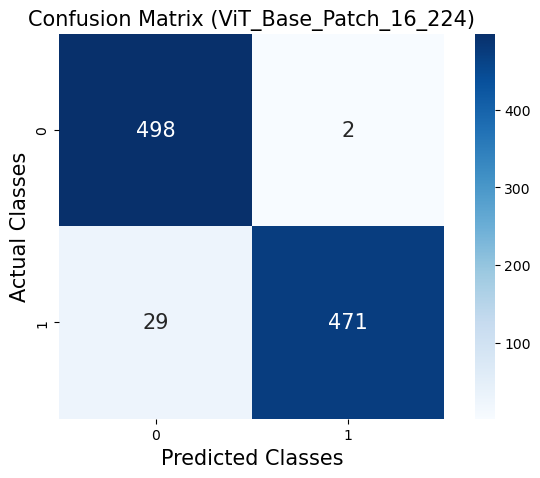



========== For Swin_Base_Patch4_Window7_224 ==========

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       500
           1       1.00      0.99      0.99       500

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



F1 Score: 0.9939997839922237
Precision: 0.9940711462450592
Recall: 0.994




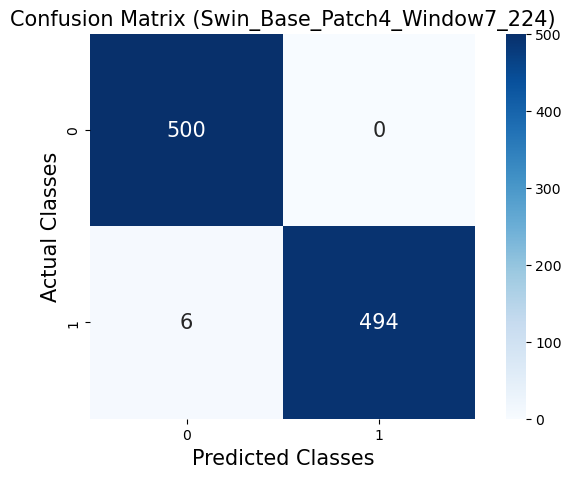



========== For Swin_Ensemble ==========

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       500
           1       0.99      1.00      1.00       500

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



F1 Score: 0.9959999839999361
Precision: 0.996007936126978
Recall: 0.996




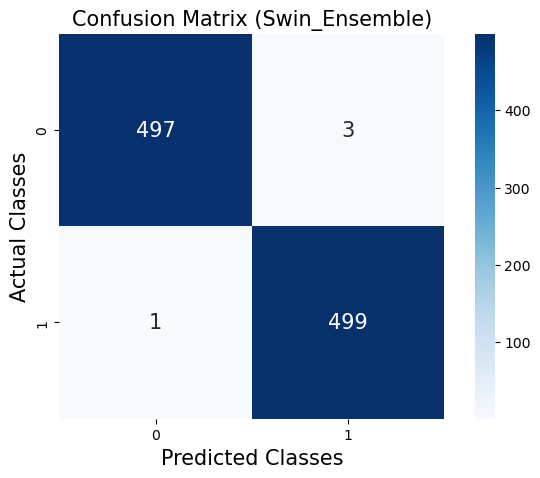

In [ ]:
def get_model_classification_report_and_confusion_matrix(model_name, y_test, y_pred):
    
    print("=" * 10, f"For {model_name}", "=" * 10)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("\n")
    print(f"F1 Score: {f1_score(y_test, y_pred, average = 'weighted')}")
    print(f"Precision: {precision_score(y_test, y_pred, average = 'weighted')}")
    print(f"Recall: {recall_score(y_test, y_pred, average = 'weighted')}")
    print("\n")
    plt.figure(figsize = (8, 5))
    ax = plt.axes()
    ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, square = True, fmt = "d", cmap = "Blues", cbar = True, annot_kws={'size': 15})
    ax.xaxis.set_tick_params(labelsize = 10)
    ax.yaxis.set_tick_params(labelsize = 10)
    plt.title(f"Confusion Matrix ({model_name})", fontsize = 15)
    plt.ylabel("Actual Classes", fontsize = 15)
    plt.xlabel("Predicted Classes", fontsize = 15)
    plt.show()
    print("\n")
    
# get_model_classification_report_and_confusion_matrix(f"{model_name}", y_test, y_pred)

get_model_classification_report_and_confusion_matrix("ViT_Base_Patch_16_224", y_test1, y_pred1)
get_model_classification_report_and_confusion_matrix("Swin_Base_Patch4_Window7_224", y_test2, y_pred2)
get_model_classification_report_and_confusion_matrix("Swin_Ensemble", y_test3, y_pred3)

One-hot encoding the arrays

In [ ]:
def one_hot_encode_array(array, num_classes):
    
    return np.squeeze(np.eye(num_classes)[array.reshape(-1)])

# y_test = one_hot_encode_array(array=y_test, num_classes=len(le.classes_))
# y_pred = one_hot_encode_array(array=y_pred, num_classes=len(le.classes_))

y_test1 = one_hot_encode_array(array=y_test1, num_classes=len(le.classes_))
y_pred1 = one_hot_encode_array(array=y_pred1, num_classes=len(le.classes_))

y_test2 = one_hot_encode_array(array=y_test2, num_classes=len(le.classes_))
y_pred2 = one_hot_encode_array(array=y_pred2, num_classes=len(le.classes_))

y_test3 = one_hot_encode_array(array=y_test3, num_classes=len(le.classes_))
y_pred3 = one_hot_encode_array(array=y_pred3, num_classes=len(le.classes_))

Converting the `y_pred_prob` array into the required format.

In [ ]:
def get_flattened_array(array):
    
    flattened_array = []
    
    for row in array:
        for col in row:
            flattened_array.append(col)
            
    return flattened_array

def get_required_array_format(array):
    
    array = get_flattened_array(array)
    array = [tensor.detach().cpu().numpy() for tensor in array]
    array = np.array(array)
    
    return array

# y_pred_prob = get_required_array_format(y_pred_prob)
y_pred_prob1 = get_required_array_format(y_pred_prob1)
y_pred_prob2 = get_required_array_format(y_pred_prob2)
y_pred_prob3 = get_required_array_format(y_pred_prob3)

# 11. ROC-AUC Curves of the trained models

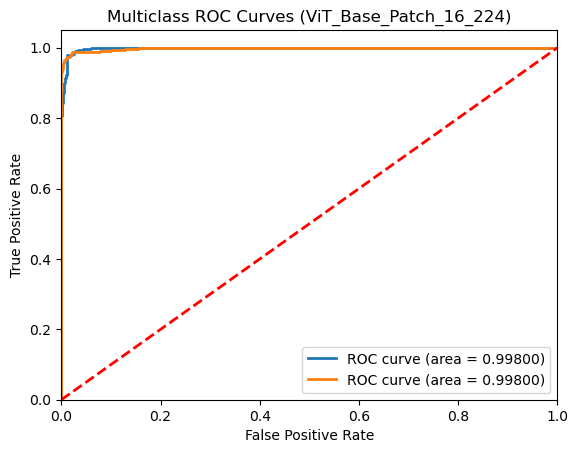

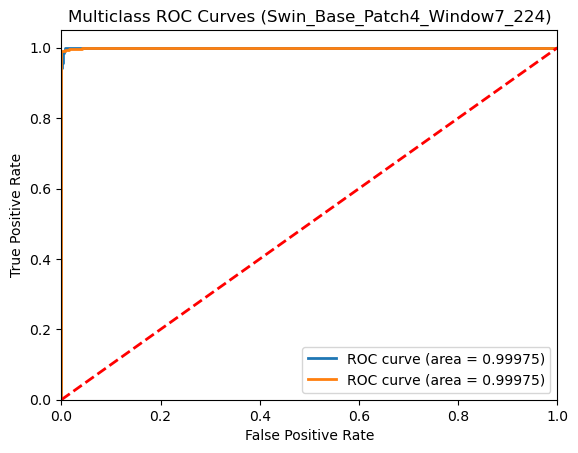

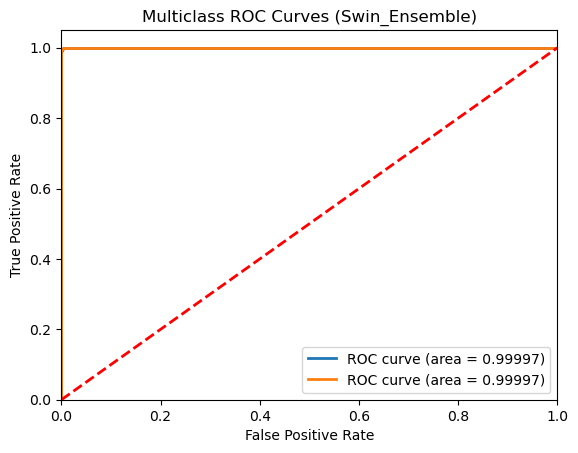

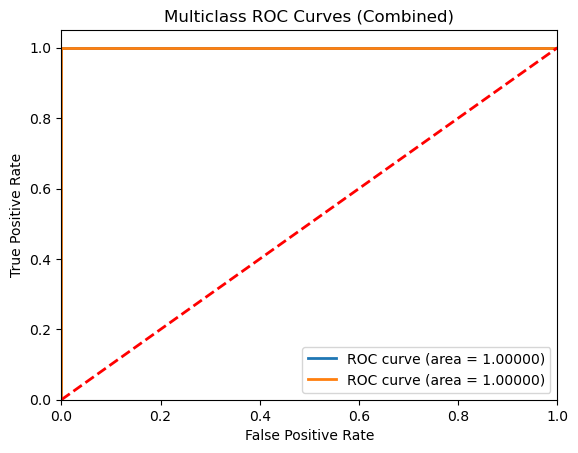

In [ ]:
def plot_auc_score_and_multiclass_roc_curves(y_test, y_pred_prob, model_name):

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = len(le.classes_)

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_prob[:, i], )
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure()
    lw = 2
    for i in range(len(le.classes_)):
        plt.plot(fpr[i], tpr[i], lw=lw, label='ROC curve (area = %0.5f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], color='red', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Multiclass ROC Curves ({model_name})')
    plt.legend(loc="lower right")
    plt.show()

# plot_auc_score_and_multiclass_roc_curves(y_test, y_pred_prob, f"{model_name}")

plot_auc_score_and_multiclass_roc_curves(y_test1, y_pred_prob1, "ViT_Base_Patch_16_224")
plot_auc_score_and_multiclass_roc_curves(y_test2, y_pred_prob2, "Swin_Base_Patch4_Window7_224")
plot_auc_score_and_multiclass_roc_curves(y_test3, y_pred_prob3, "Swin_Ensemble")

combined_y_test = np.add(np.add(y_test1, y_test2), y_test3) / 3
combined_y_pred_prob = np.add(np.add(y_pred_prob1, y_pred_prob2), y_pred_prob3) / 3
plot_auc_score_and_multiclass_roc_curves(combined_y_test, combined_y_pred_prob, "Combined")

# 12. AUC Score for the trained models

In [ ]:
def get_auc_score(y_test, y_pred_prob, model_name):
    
    print(10 * "=", f"For {model_name}", 10 * "=")
    
    auc_ovo = roc_auc_score(y_test, y_pred_prob, multi_class="ovo")
    auc_ovr = roc_auc_score(y_test, y_pred_prob, multi_class="ovr")
    
    print('AUC (OVO): %.5f' % auc_ovo)
    print('AUC (OVR): %.5f' % auc_ovr)

# get_auc_score(y_test, y_pred_prob, f"{model_name}")
get_auc_score(y_test1, y_pred_prob1, "ViT_Base_Patch_16_224")
get_auc_score(y_test2, y_pred_prob2, "Swin_Base_Patch4_Window7_224")
get_auc_score(y_test3, y_pred_prob3, "Swin_Ensemble")
get_auc_score(combined_y_test, combined_y_pred_prob, "Combined")

========== For ViT_Base_Patch_16_224 ==========
AUC (OVO): 0.99800
AUC (OVR): 0.99800
========== For Swin_Base_Patch4_Window7_224 ==========
AUC (OVO): 0.99975
AUC (OVR): 0.99975
========== For Swin_Ensemble ==========
AUC (OVO): 0.99997
AUC (OVR): 0.99997
========== For Combined ==========
AUC (OVO): 1.00000
AUC (OVR): 1.00000


# 13. Conclusion

Augmentations were applied to the dataset and OOM (Out Of Memory) errors were prevented by using smaller models and a lower batch size.

For this task the following models were trained:

- ViT_Base_Patch_16_224
- Swin_Base_Patch4_Window7_224
- Ensemble of Swin_s3_Base_224 and Swinv2_cr_Base_224

The final predictions of all the aforementioned models were **averaged** to achieve the best performace.